In [1]:
cd ..

/home/uniq/Documents/Deep Learning/VANILLA GAN


In [2]:
import os 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

from PIL import Image
from torchsummary import summary
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="PIL.Image")


In [3]:
#Hyper parameters
lr = 0.001
batch_size = 64
num_epochs = 10
img_path = './data/Male and Female face dataset'  
device = torch. device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# Define transformation for preprocessing
transform = transforms.Compose([
    transforms.Resize((64)),# Resize images to 128x128
    transforms.CenterCrop(64),  # Crop images to 128x128 about
    transforms.ToTensor(),                       # Convert image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1,1]
])

# Dataset Preparations

In [5]:
class faceDataset():
    def __init__(self, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.image_paths = []
        
       # Collect all image paths
        for subdir, _, files in os.walk(img_path):
            for file in files:
                if file.endswith(('jpg', 'jpeg', 'png')):  # Filter for image files
                    self.image_paths.append(os.path.join(subdir, file))
            print(f"Found {len(self.image_paths)} images")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Open image in RGB mode
        
        if self.transform:
            image = self.transform(image)
        return image
    
faceData = faceDataset(img_path, transform=transform)
faceData[0].shape


Found 0 images
Found 2717 images
Found 5400 images


torch.Size([3, 64, 64])

In [6]:
faceDataloader = DataLoader(faceData, batch_size = batch_size, shuffle=True)

In [7]:
next(iter(faceDataloader)).shape

torch.Size([64, 3, 64, 64])

## Model Building

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is (3) x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x).view(-1,1)


In [9]:
discriminator = Discriminator()
discriminator(torch.rand(10,3,64,64)).shape


torch.Size([10, 1])

In [10]:
# Move the discriminator to the appropriate device (GPU or CPU)
discriminator = Discriminator().to(device)

# Use the same device for the summary call
summary(discriminator, (3, 64, 64), device=str(device))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

In [11]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.main = nn.Sequential(
            # input is z_dim x 1 x 1
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.main(x)

In [12]:
generator = Generator()
generator(torch.rand(10,100,1,1)).shape

torch.Size([10, 3, 64, 64])

In [13]:
generator = Generator().to(device)
summary(generator, (100, 1, 1), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [14]:
def noise(batch_size, device):
    return torch.randn(batch_size, 100, 1, 1, device=device)

noise(64, device).shape

torch.Size([64, 100, 1, 1])

## Model Configuration 

In [15]:
def visualize_samples(generator, device, num_samples=8):
    generator.eval()
    noise_vec = torch.randn(num_samples, 100, 1, 1, device=device)
    with torch.no_grad():
        fake = generator(noise_vec).detach().cpu()
    # Denormalize if needed
    fake = (fake * 0.5) + 0.5
    fig, axes = plt.subplots(1, num_samples, figsize=(15,4))
    for i in range(num_samples):
        axes[i].imshow(fake[i].permute(1,2,0))
        axes[i].axis('off')
    plt.show()

In [16]:
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)
criteria = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5,0.999))  # CHANGED
g_optimizer = optim.Adam(generator.parameters(),     lr=0.0002, betas=(0.5,0.999))  # CHANGED


In [17]:
def train_discriminator(discriminator, criteria, d_optimizer, real_image, fake_image, device):
    discriminator.train()
    d_optimizer.zero_grad()
    
    # Smooth labels for real and fake samples
    real_labels = torch.full((len(real_image), 1), 0.9, device=device)  # slight smoothing for real
    fake_labels = torch.zeros(len(fake_image), 1, device=device)         # zero for fake


    # Forward pass for real images
    real_output = discriminator(real_image)
    real_loss = criteria(real_output, real_labels)

    # Forward pass for fake images
    fake_output = discriminator(fake_image)
    fake_loss = criteria(fake_output, fake_labels)

    # Combine losses
    total_loss = real_loss + fake_loss

    # Backpropagate and update discriminator weights
    total_loss.backward()
    d_optimizer.step()
    
    return total_loss


In [18]:
torch.zeros(64,1).shape

torch.Size([64, 1])

In [19]:
def train_generator(discriminator, criteria, g_optimizer, fake_image, device):
    g_optimizer.zero_grad()
    output = discriminator(fake_image)
    loss = criteria(output, torch.ones(len(output),1).to(device=device))  # generator should generate image that should be classified as 1 so torch.ones 
    loss.backward()
    g_optimizer.step()
    return loss

Train 1 of 10: 100%|██████████| 85/85 [03:04<00:00,  2.17s/it]

Epoch 1/10
Generator Loss: 764.3462, Discriminator Loss: 53.7551


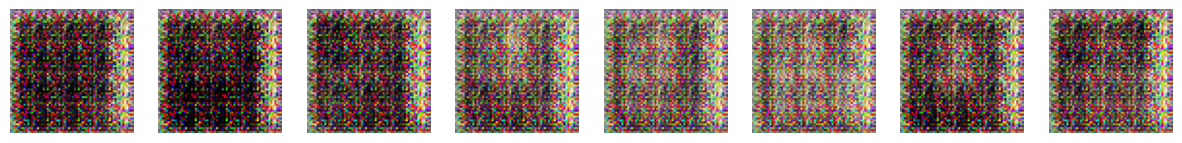

Train 2 of 10: 100%|██████████| 85/85 [03:01<00:00,  2.14s/it]

Epoch 2/10
Generator Loss: 277.4841, Discriminator Loss: 77.7546


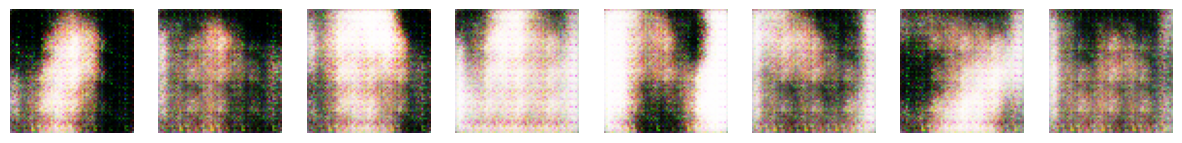

Train 3 of 10: 100%|██████████| 85/85 [03:03<00:00,  2.16s/it]

Epoch 3/10
Generator Loss: 264.9610, Discriminator Loss: 77.8401


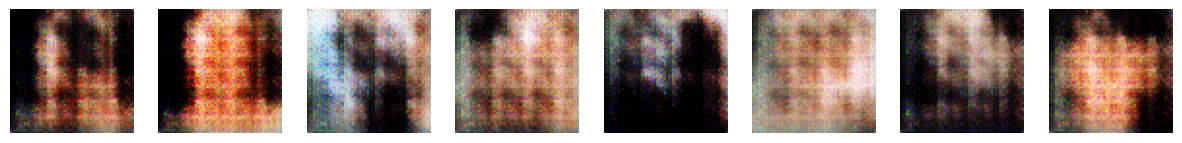

Train 4 of 10: 100%|██████████| 85/85 [03:11<00:00,  2.25s/it]

Epoch 4/10
Generator Loss: 281.0492, Discriminator Loss: 72.6030


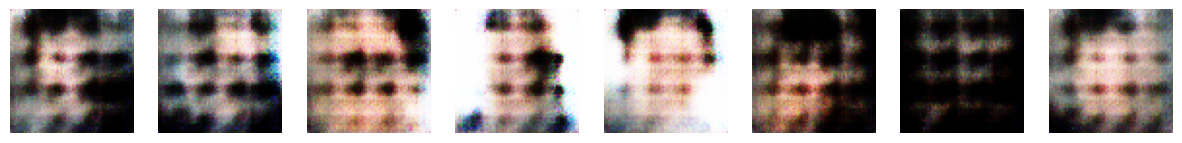

Train 5 of 10: 100%|██████████| 85/85 [03:05<00:00,  2.18s/it]

Epoch 5/10
Generator Loss: 271.0971, Discriminator Loss: 69.4459


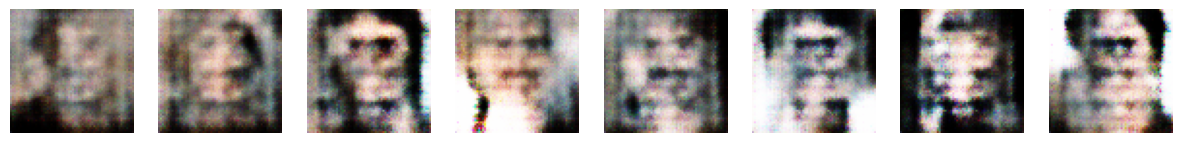

Train 6 of 10: 100%|██████████| 85/85 [03:07<00:00,  2.20s/it]

Epoch 6/10
Generator Loss: 286.7782, Discriminator Loss: 65.4277


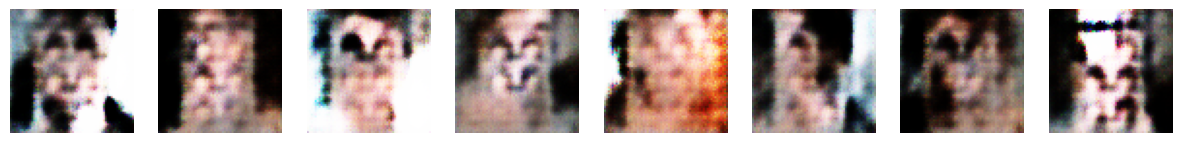

Train 7 of 10: 100%|██████████| 85/85 [03:10<00:00,  2.25s/it]


Epoch 7/10
Generator Loss: 299.7089, Discriminator Loss: 64.8332


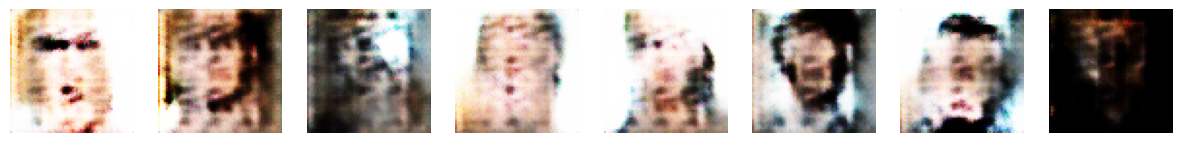

Train 8 of 10: 100%|██████████| 85/85 [03:07<00:00,  2.20s/it]

Epoch 8/10
Generator Loss: 298.7787, Discriminator Loss: 65.9318


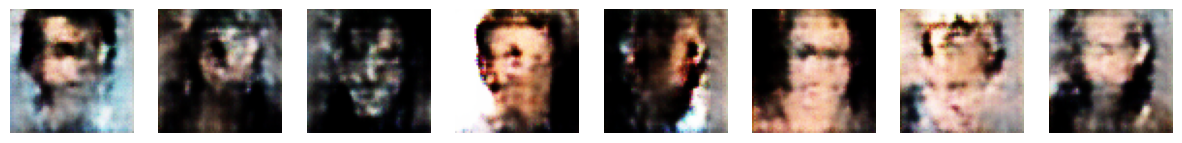

Train 9 of 10: 100%|██████████| 85/85 [03:14<00:00,  2.29s/it]

Epoch 9/10
Generator Loss: 301.9818, Discriminator Loss: 60.9911


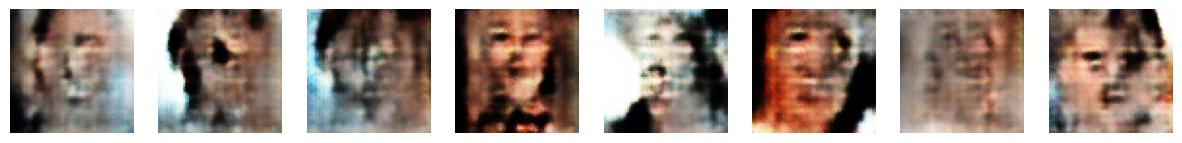

Train 10 of 10: 100%|██████████| 85/85 [03:14<00:00,  2.29s/it]

Epoch 10/10
Generator Loss: 312.7196, Discriminator Loss: 58.6469


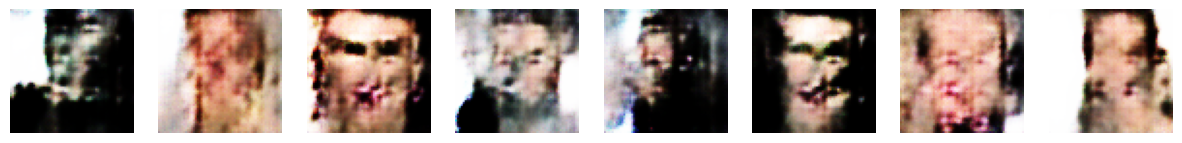

In [20]:
total_gen_loss, total_disc_loss = [], []

# Loop over epochs
for epoch in range(1, num_epochs + 1):
    epoch_gen_loss = 0
    epoch_disc_loss = 0

    # Loop over batches
    for images in tqdm(faceDataloader, desc=f'Train {epoch} of {num_epochs}'):

        # Prepare real and fake images
        real_image = images.to(device=device)   # shape: (batch_size, 3, 64, 64)

        fake_image = generator(noise(len(images), device=device))
        # Train the discriminator
        disc_loss = train_discriminator(discriminator, criteria, d_optimizer, real_image, fake_image, device)

        # Generate new fake images
        fake_image = generator(noise(len(images), device=device))

        # Train the generator
        gen_loss = train_generator(discriminator, criteria, g_optimizer, fake_image, device)

        # Accumulate losses for the epoch
        epoch_gen_loss += gen_loss.item()
        epoch_disc_loss += disc_loss.item()

    # Print epoch losses
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Generator Loss: {epoch_gen_loss:.4f}, Discriminator Loss: {epoch_disc_loss:.4f}")

    # Visualize generated samples
    if epoch %1  == 0:  # Visualize every epoch
        visualize_samples(generator, device)

    # Store losses for later visualization
    total_gen_loss.append(epoch_gen_loss)
    total_disc_loss.append(epoch_disc_loss)


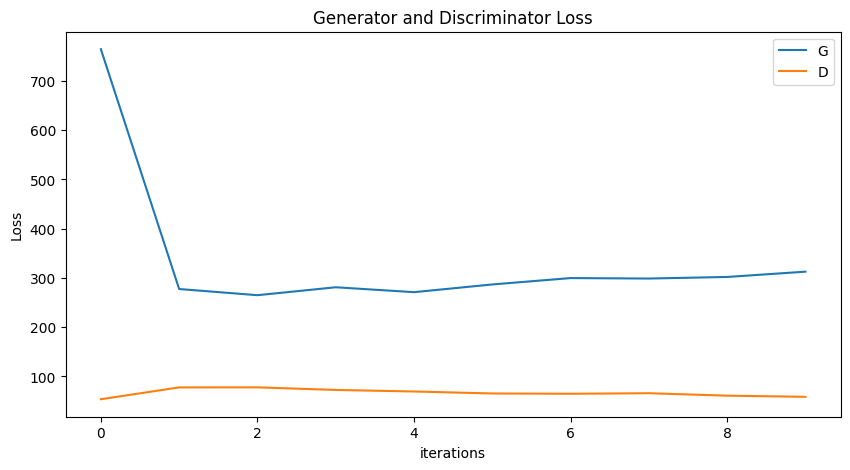

In [21]:
# Plot final losses, etc.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss")
plt.plot(total_gen_loss,label="G")
plt.plot(total_disc_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Saving the Models
You can also save the trained models:
```python
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')
```
Then later:
```python
G = Generator(z_dim=100)
G.load_state_dict(torch.load('generator.pth'))
```


In [22]:
torch.save(generator.state_dict(), 'generatorDCafno.pth')
torch.save(discriminator.state_dict(), 'discriminatorDCafno.pth')